# Myeloid annotation v2.0

Re-embedding myeloid cells:
- removing carry-over lymphoid cells
- including pDCs

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

In [2]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'

## Load data

In [3]:
## Load HSC_immune to get pDCs
split = "HSC_IMMUNE"
adata_2 = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
adata_2 = adata_2[~adata_2.obs_names.isin(mat_barcodes["x"])]

# Add annotation obs
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
# adata_2 = adata_2[adata_2.obs_names.isin(anno_obs.index)].copy()
adata_2 = adata_2[adata_2.obs_names.isin(anno_obs.index)]
adata_2.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata_2.obs_names]["anno_lvl_2_final_clean"]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
Trying to set attribute `.obs` of view, copying.


In [ ]:
sum(adata_2.obs["anno_lvl_2_final_clean"] == "pDC")

In [17]:
split = "MYELOID"
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
X_umap = np.load(data_dir + 'scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.MYELOID.scVI_out.UMAP.npy')
adata.obsm["X_umap"] = X_umap

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [18]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

# Add annotation obs
# anno_dir = "/nfs/team205/ed6/bin/Pan_fetal_immune/metadata/manual_annotation/"
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [19]:
add_obs = anno_obs[['uniform_label',
       'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ',
       'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex',
       'Processing_method', 'AnnatomicalPart', 'Sample']]

In [20]:
adata.obs = pd.concat([adata.obs, add_obs.loc[adata.obs_names]],1)

In [21]:
adata.obs["anno_lvl_2_final_clean"].unique()

array(['DC3', 'DC2', 'DC1', 'DOUBLET_LYMPHOID_MACROPHAGE',
       'PROLIFERATING_MACROPHAGE', 'EO/BASO/MAST', 'PRE_PRO_B', 'GMP',
       'CD14_MONO', 'CD14+_MACROPHAGE', 'PROMYELOCYTE', 'LMPP_ELP',
       'OLFML3+_MICROGLIA', 'PROMONOCYTE_(PROLIFERATING)',
       'CD16+_MACROPHAGE', 'MEMP', 'NEUTROPHIL', 'PROMONOCYTE',
       'YS_MACROPHAGE', 'BM_CD14_MONO', 'HIGH_MITO_DC', 'CMP',
       'CYCLING_MPP', 'DOUBLET_ERY_B', 'KUPFFER_RP_MACROPHAGE', 'HSC_MPP',
       'LOW_QUALITY_MACROPHAGE', 'PROLIFERATING_KUPFFER_RP_MACROPHAGE',
       'YS_ERY_MACROPHAGE', 'LOW_Q_INCONSISTENT', 'MEP', 'EARLY_MK',
       'SPLENIC_MACROPHAGE', 'CYCLING_MEMP', 'DN(early)_T', 'DN(P)_T',
       'OSTEOCLAST'], dtype=object)

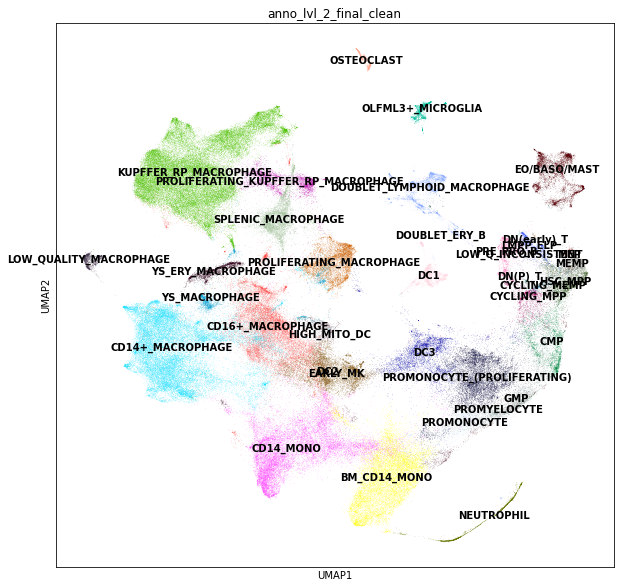

In [24]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color="anno_lvl_2_final_clean", legend_loc="on data")

In [25]:
exclude_ct = ["DOUBLET_LYMPHOID_MACROPHAGE", 'PRE_PRO_B','DN(early)_T', 'DN(P)_T','LOW_Q_INCONSISTENT']

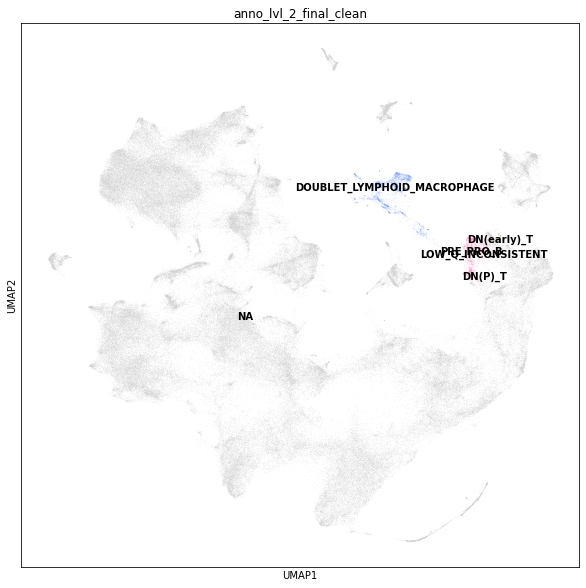

In [26]:
sc.pl.umap(adata, color="anno_lvl_2_final_clean", legend_loc="on data", groups=exclude_ct)